# The prior_distributions plot in the paper.

In [1]:
%matplotlib inline

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import scipy.stats as sps
import starspot as ss

plotpar = {'axes.labelsize': 25,
           'font.size': 12,
           'legend.fontsize': 15,
           'xtick.labelsize': 15,
           'ytick.labelsize': 15,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the data.

In [4]:
df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,20,21,22,28,30,54,55,56,74,76,155,156,176) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Define functions for Gaussians and KDEs.

In [5]:
def kde(v, xlim):
    kernel = sps.gaussian_kde(v)
    xs = np.linspace(xlim[0], xlim[1], 1000)
    return xs, kernel(xs)

def gauss(x, mu, sig):
    return 1./(sig * np.sqrt(2 * np.pi)) * np.exp(-.5 * (x - mu)**2 / sig**2)

def mean_and_var(vx, vy, vz, lnD):
    V = np.stack((vx, vy, vz, lnD), axis=0)
    return np.mean(V, axis=1), np.cov(V)

Remove NaNs and sigma clip.

In [13]:
# Just stars with RVs
lnD = np.log(df.r_est.values * 1e-3)
finite = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) & np.isfinite(df.vz.values) & np.isfinite(lnD)
vx, vy, vz, lnD = df.vx.values[finite], df.vy.values[finite], df.vz.values[finite], lnD[finite]

nsigma = 3
mx = ss.sigma_clip(vx, nsigma=nsigma)
my = ss.sigma_clip(vy, nsigma=nsigma)
mz = ss.sigma_clip(vz, nsigma=nsigma)
md = ss.sigma_clip(lnD, nsigma=nsigma)
m = mx & my & mz & md

Define bright and faint stars.

In [14]:
b = df.phot_g_mean_mag.values[finite][m] < 13.
f = df.phot_g_mean_mag.values[finite][m] > 13.

mu_faint, cov_faint = mean_and_var(vx[m][f], vy[m][f], vz[m][f], lnD[m][f])
mu_bright, cov_bright = mean_and_var(vx[m][b], vy[m][b], vz[m][b], lnD[m][b])
mu_all, cov_all = mean_and_var(vx[m], vy[m], vz[m], lnD[m])

Variables for plotting

In [15]:
box = 200
medx, medy, medz = np.median(vx), np.median(vy), np.median(vz)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 2)

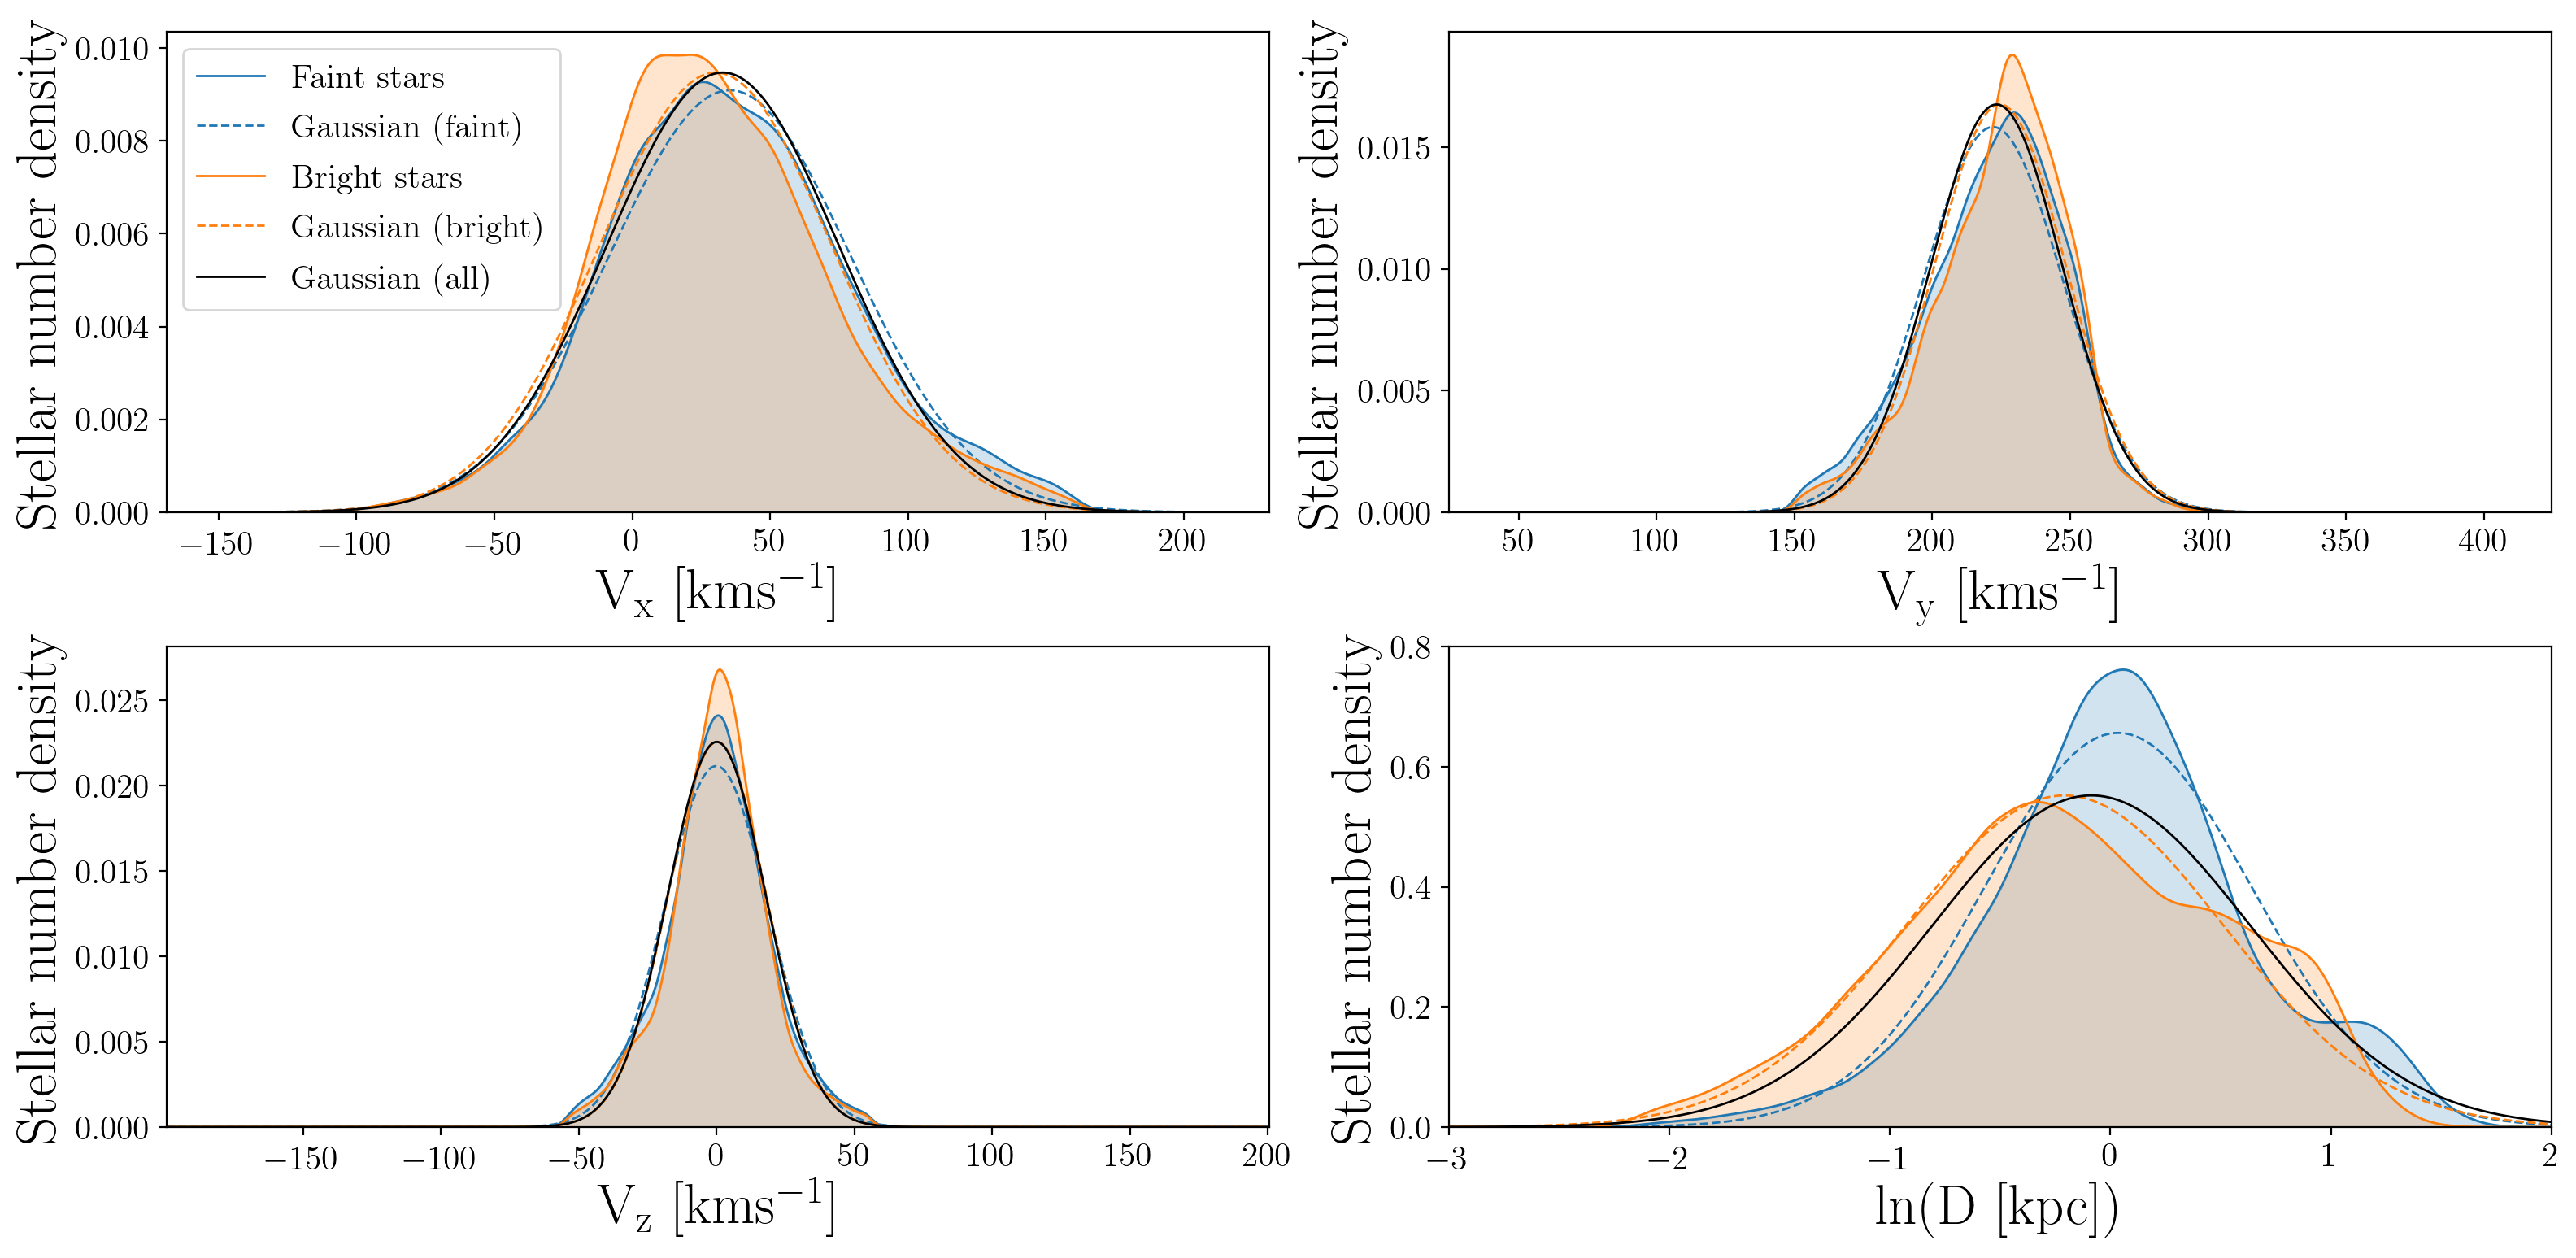

In [20]:
fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(221)

c0, c1 = "C0", "C1"
ylabel = "$\mathrm{Stellar~number~density}$"

# KDEs
xs, k = kde(vx[m][f], xlim)
ax0.plot(xs, k, color=c0, lw=1, label="$\mathrm{Faint~stars}$")
ax0.fill_between(xs, np.zeros(len(xs)), k, color=c0, alpha=.2)
ax0.plot(xs, gauss(xs, mu_faint[0], np.sqrt(cov_faint[0, 0])), color=c0, lw=1, ls="--", rasterized=True,
         label="$\mathrm{Gaussian~(faint)}$")
_, k = kde(vx[m][b], xlim)
ax0.plot(xs, k, color=c1, lw=1, label="$\mathrm{Bright~stars}$")
ax0.fill_between(xs, np.zeros(len(xs)), k, color=c1, alpha=.2)

# Gaussian priors
ax0.plot(xs, gauss(xs, mu_bright[0], np.sqrt(cov_bright[0, 0])), color=c1, lw=1, ls="--", rasterized=True,
         label="$\mathrm{Gaussian~(bright)}$")
ax0.plot(xs, gauss(xs, mu_all[0], np.sqrt(cov_bright[0, 0])), color="k", lw=1, ls="-", rasterized=True,
         label="$\mathrm{Gaussian~(all)}$")
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel(ylabel)
ax0.set_xlim(xlim)
hlims = ax0.get_ylim()
ax0.set_ylim(0, hlims[1])
ax0.legend()

ax1 = fig.add_subplot(222)
xs, k = kde(vy[m][f], ylim)
ax1.plot(xs, k, color="C0", lw=1)
ax1.fill_between(xs, np.zeros(len(xs)), k, color=c0, alpha=.2)
ax1.plot(xs, gauss(xs, mu_faint[1], np.sqrt(cov_faint[1, 1])), color="C0", lw=1, ls="--", rasterized=True)
_, k = kde(vy[m][b], ylim)
ax1.plot(xs, k, color="C1", lw=1)
ax1.fill_between(xs, np.zeros(len(xs)), k, color=c1, alpha=.2)
ax1.plot(xs, gauss(xs, mu_bright[1], np.sqrt(cov_bright[1, 1])), color="C1", lw=1, ls="--", rasterized=True)
ax1.plot(xs, gauss(xs, mu_all[1], np.sqrt(cov_bright[1, 1])), color="k", lw=1, ls="-", rasterized=True)
ax1.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax1.set_xlim(200, 280)
ax1.set_ylabel(ylabel)
ax1.set_xlim(ylim)
hlims = ax1.get_ylim()
ax1.set_ylim(0, hlims[1])

ax2 = fig.add_subplot(223)
xs, k = kde(vz[m][f], zlim)
ax2.plot(xs, k, color="C0", lw=1) #, label="$\mathrm{Faint~stars}$")
ax2.fill_between(xs, np.zeros(len(xs)), k, color=c0, alpha=.2)
ax2.plot(xs, gauss(xs, mu_faint[2], np.sqrt(cov_faint[2, 2])), color="C0", lw=1, ls="--", rasterized=True)
_, k = kde(vz[m][b], zlim)
ax2.plot(xs, k, color="C1", lw=1)
ax2.fill_between(xs, np.zeros(len(xs)), k, color=c1, alpha=.2)
ax2.plot(xs, gauss(xs, mu_bright[2], np.sqrt(cov_bright[2, 2])), color="C1", lw=1, ls="--", rasterized=True)
ax2.plot(xs, gauss(xs, mu_all[2], np.sqrt(cov_bright[2, 2])), color="k", lw=1, ls="-", rasterized=True)
ax2.set_xlabel("$\mathrm{V_z~[kms^{-1}]}$")
ax2.set_xlim(-50, 50)
ax2.set_ylabel(ylabel)
ax2.set_xlim(zlim)
hlims = ax2.get_ylim()
ax2.set_ylim(0, hlims[1])

ax3 = fig.add_subplot(224)
xs, k = kde(lnD[m][f], dlim)
ax3.plot(xs, k, color="C0", lw=1) #, label="$\mathrm{Faint~stars}$")
ax3.fill_between(xs, np.zeros(len(xs)), k, color=c0, alpha=.2)
ax3.plot(xs, gauss(xs, mu_faint[3], np.sqrt(cov_faint[3, 3])), color="C0", lw=1, ls="--", rasterized=True)
_, k = kde(lnD[m][b], dlim)
ax3.plot(xs, k, color="C1", lw=1) #, label="$\mathrm{Bright~stars}$")
ax3.fill_between(xs, np.zeros(len(xs)), k, color=c1, alpha=.2)
ax3.plot(xs, gauss(xs, mu_bright[3], np.sqrt(cov_bright[3, 3])), color="C1", lw=1, ls="--", rasterized=True)
ax3.plot(xs, gauss(xs, mu_all[3], np.sqrt(cov_bright[3, 3])), color="k", lw=1, ls="-", rasterized=True)
ax3.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax3.set_ylabel(ylabel)
ax3.set_xlim(dlim)
hlims = ax3.get_ylim()
ax3.set_ylim(0, hlims[1])

plt.tight_layout()
plt.subplots_adjust(hspace=.28)
plt.savefig("../plots/prior_distributions")
plt.savefig("../paper/prior_distributions.pdf")